### OLIGOMERS CLASSIFIER

This is a simple toy model aimed to classify three different types of oligomers: peptides, plastics and oligosaccharides. A dataset has been generated running 'polymer_generator.py', containing around 20000 different sequences of oligomers (each oligomers contains 3 to 7 monomers). Each example contains the SMILES, label and Morgan fingerprint of the molecule as a 2048 bit vector (each bit is considered as a different feature). The dataset is built generating random SMILES for each class and then creating their corresponding Morgan fingerprint using the RDKit library.

Using these data, we will try to build a neural network that can classify the oligomers based on their class.

### Neural Network Polymer Classifier

First, we will import the dataset that was generated by the script.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv('polymers_dataset.csv')

In [3]:
data

,Unnamed: 0,smiles,label,0,1,2,3,4,5,6,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,C(Cl)CCC(c1ccccc1)CCC(Cl)C,plastic,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1,OC(=O)[C@]([H])(CC1=CC=C(O)C=C1)NC(=O)[C@]([H]...,peptide,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,O[C@]([C@@]([H])(CO)O[C@@](O)([H])[C@]([H])1O)...,oligosaccharide,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,C(Cl)CCC(c1ccccc1)C(Cl)CCC,plastic,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,CCC(Cl)CC(Cl)CCCC(C)CCC(c1ccccc1),plastic,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20604,20604,C(Cl)CCCC(C)CC(Cl)CC(C)CC(Cl)C,plastic,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
20605,20605,O[C@@]([C@]([H])(CO)O[C@](O)([H])[C@@]([H])1O)...,oligosaccharide,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20606,20606,O[C@]([C@]([H])(CO)O[C@](O)([H])[C@]([H])1O)([...,oligosaccharide,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20607,20607,OC(=O)[C@@]([H])(CS)NC(=O)[C@]([H])(CCSC)NC(=O...,peptide,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each row corresponds to one oligomer and contains its SMILES, class and the corresponding Morgan Fingerprint as a bit vector. Each bit represent one feature and we want to see if this information is able to learn the underlying structure of each class. We can visualize the molecular structures using RDKit.

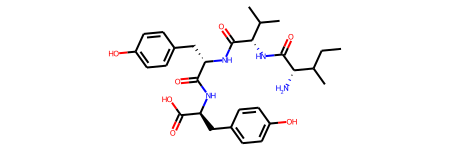

In [16]:
from rdkit import Chem

mol = Chem.MolFromSmiles(data['smiles'][1])

mol

This structure corresponds to a peptide.

Prepare train and test sets. For the predictor features, we take the 2048 variables corresponding to the fingerprint. In the case of the target variable, we use one-hot encoding to transform each class into a vector.

In [4]:
#Select predictor variables
X = data.iloc[:,3:].values

#Transform target variable using OneHotEncoder()
ohe = OneHotEncoder()

y_one_hot = ohe.fit_transform(np.array(data['label']).reshape(-1,1)).toarray()

#Create train and test sets, using 20% of the data for the test set
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.2, random_state=0)

Now we create the Neural Network using Keras. In this case, the input will be a vector with 2048 features (the fingerprint) and the network will contain two hidden layers, obtaining a 3x1 vector as the output.

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense

# Neural network
model = Sequential()
model.add(Dense(128, input_dim=2048, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

#Summarize and compile model
model.summary()
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 264,387
Trainable params: 264,387
Non-trainable params: 0
_________________________________________________________________


Time to train the network. We choose a batch size of 64 and 50 epochs. Note: no GPU acceleration was required to train the network.

In [6]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
258/258 [==============================] - 2s 6ms/step - loss: 0.0350 - accuracy: 0.9917 - val_loss: 3.2675e-04 - val_accuracy: 1.0000
Epoch 2/50
258/258 [==============================] - 1s 5ms/step - loss: 1.3965e-04 - accuracy: 1.0000 - val_loss: 9.7778e-05 - val_accuracy: 1.0000
Epoch 3/50
258/258 [==============================] - 1s 5ms/step - loss: 4.7541e-05 - accuracy: 1.0000 - val_loss: 4.9410e-05 - val_accuracy: 1.0000
Epoch 4/50
258/258 [==============================] - 1s 5ms/step - loss: 2.3665e-05 - accuracy: 1.0000 - val_loss: 3.0794e-05 - val_accuracy: 1.0000
Epoch 5/50
258/258 [==============================] - 1s 6ms/step - loss: 1.4033e-05 - accuracy: 1.0000 - val_loss: 2.1422e-05 - val_accuracy: 1.0000
Epoch 6/50
258/258 [==============================] - 1s 4ms/step - loss: 9.1798e-06 - accuracy: 1.0000 - val_loss: 1.5885e-05 - val_accuracy: 1.0000
Epoch 7/50
258/258 [==============================] - 2s 6ms/step - loss: 6.3837e-06 - accuracy: 1.0000 

Apparently, the model converges very soon and we get a test accuracy of 1.0. Let's save the predicted values and plot a confusion matrix

129/129 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Confusion Matrix-Neural Network')

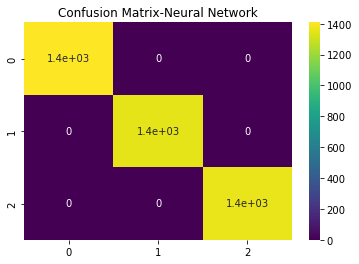

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Compute predicted values
prediction = model.predict(X_test).round()

#We create a function to transform the one-hot encoded arrays into an array of single values
def decoder(values):
  
  '''This function takes a vector of one-hot encoded arrays and returns
  the index of the corresponding object (0, 1 or 2)'''
    
  decoded = []

  for i in values:
    x = np.argmax(i)
    decoded.append(x)
  
  return decoded
  

predicted = decoder(prediction)

real = decoder(y_test)

#Create confusion matrix
conf = confusion_matrix(predicted, real)

sns.heatmap(conf, annot=True, cmap = 'viridis')
plt.title('Confusion Matrix-Neural Network')

Perfect classification! The model does not miss any oligomer. Thus, we can see that the neural network is able to distinguish correctly each oligomer class. 

### Random Forest

The Neural Network has worked perfectly, but is a complex model needed in this case? Let's try to create a Random Forest Classifier and see how it works.

In [9]:
from sklearn.ensemble import RandomForestClassifier

#Create Random Forest
rf = RandomForestClassifier(random_state=0)

#Train Random Forest
rf.fit(X_train, y_train)

#Compute Random Forest accuracy
score = rf.score(X_test, y_test)

print('Random Forest accuracy: {0}'.format(score))

Random Forest accuracy: 1.0


An accuracy of 1

Text(0.5, 1.0, 'Confusion matrix-Random Forest')

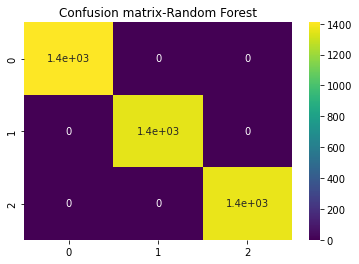

In [10]:
rf_prediction = decoder(rf.predict(X_test))

rf_true = decoder(y_test)

cm = confusion_matrix(rf_prediction, rf_true)

sns.heatmap(cm, annot=True, cmap = 'viridis')

plt.title('Confusion matrix-Random Forest')

As we can see, a Random Forest model can also classify perfectly all the oligomers. Thus, we don't need a Neural Network to solve this problem and we can use this simpler model instead.

### Unsupervised learning: clustering

Previous results suggest that the predictor variables can separate the three classes easily. Let's try to see if we are able to cluster the molecules in three different groups using unsupervised learning. First, we try to reduced the 2048 features into 2 using PCA.

C:\Users\Usuario\anaconda3\envs\my-rdkit-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'PCA clustering')

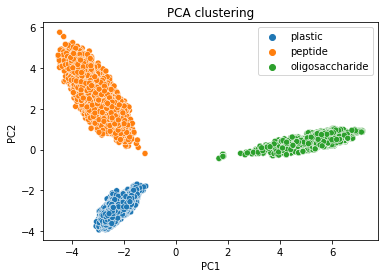

In [11]:
from sklearn.decomposition import PCA

#Create PCA with 2 components
pca = PCA(n_components=2)

#Reduce dimensions of the original set
coords = pca.fit_transform(X)

#Plot the groups using 
sns.scatterplot(coords[:,0], coords[:,1], hue=data['label'].values)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA clustering')

We can observe three clusters, each one corresponding to each of our oligomer classes. PCA can separate the oligomers perfectly. Let's try KMeans clustering.

Text(0.5, 1.0, 'Kmeans inertia vs k')

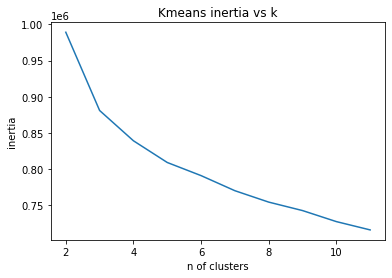

In [12]:
from sklearn.cluster import KMeans

inertia = []
clusters = []

#Train KMean models with different k and save their inertia
for k in range(2,12):

    kmeans = KMeans(n_clusters=k)
    
    kmeans.fit(X)
    
    inertia.append(kmeans.inertia_)
    
    clusters.append(k)

#Plot inertia vs number of clusters (elbow method)
plt.plot(clusters, inertia)

plt.xlabel('n of clusters')
plt.ylabel('inertia')
plt.title('Kmeans inertia vs k')

In principle, applying the elbow method we should see a clear elbow for k=3 (as we expect 3 clusters). Let's train a KMeans model with k=3 and see how well it clusters the oligomers (we plot the labels obtained after fitting the model vs using the PCA coordinates).

C:\Users\Usuario\anaconda3\envs\my-rdkit-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'K-Means clustering')

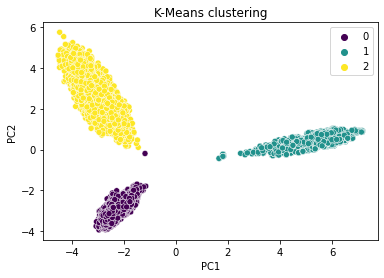

In [13]:
kmeans = KMeans(n_clusters=3)

#Fit model
kmeans.fit(X)

#Visualize the clusters using model labels and PCA coordinates
sns.scatterplot(coords[:,0], coords[:,1], kmeans.labels_, palette='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means clustering')

The model can also cluster correctly all the molecules excepting one that is clustered as 2 (plastic) when it corresponds to cluster 1 (peptides). In any case, we have observed how unsupervised learning algorithms can be also used to distinguish these species.

### Conclusion

We have built a simple oligomer classifier training an artificial neural network. The model is able to classify correctly all the samples in the test set and shows a perfect performance. A simpler Random Forest model has laso been tested, obtaining the same result (perfect classification). PCA and KMeans clustering have been applied to the dataset, finding three clusters corresponding to each class. 

The results show how Morgan fingerprint can be used to train the algorithms with success, capturing enough structural information to distinguish each class. 